In [27]:
import os
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from tqdm import tqdm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import gc
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import sklearn as sk
import lightgbm
SEED = 42
os.chdir(r'D:\AFT\Feature_Engineer_Kaggle_2025')
import numpy as np
import pandas as pd
import os
base_path = r'D:\AFT\Feature_Engineer_Kaggle_2025\Factors'  # 原始字符串
# 检查路径是否存在
if os.path.exists(base_path):
    for dirname, _, filenames in os.walk(base_path):
        for filename in filenames:
            print(os.path.join(dirname, filename))
else:
    print(f"路径不存在: {base_path}")

D:\AFT\Feature_Engineer_Kaggle_2025\Factors\cross_section_features.parquet
D:\AFT\Feature_Engineer_Kaggle_2025\Factors\ipynb_features.parquet
D:\AFT\Feature_Engineer_Kaggle_2025\Factors\market_features.parquet
D:\AFT\Feature_Engineer_Kaggle_2025\Factors\rank9_features.parquet
D:\AFT\Feature_Engineer_Kaggle_2025\Factors\timeseries_features.parquet


1️⃣ SHAP 计算的优化实践
处理大规模数据时尝试了不同的SHAP计算方法策略：有的通过分批次（batch）处理来避免内存溢出，有的则尝试了多种并行加速方案。但是LightGBM内置的 predict_contribute=True 接口底层由高度优化的C++代码实现，本身效率高外部加速手段的提升空间有限。
2️⃣ Data Shapley
用一个简单的MLP模型复现了Data Shapley方法。核心在于量化每个训练样本对模型性能的贡献度，通过在训练过程中追踪梯度（一阶导）和Hessian矩阵（二阶导）等相关参数来实现。与特征重要性目标不太一致（目前看来，我再看看方法能不能迁移），在LLM训练中可有效识别出对模型产生负面贡献的“有害样本”。
📌 避坑提示
模型训练中的数值稳定性至关重要，具体技巧已批注在代码和Markdown中（如归一化、损失函数构建、梯度裁剪等），有可能导致梯度爆炸返回NaN。

In [28]:
X= pd.read_parquet(r"C:\Users\47318\Desktop\feature importance\X_train.parquet")
y = pd.read_pickle(r"C:\Users\47318\Desktop\feature importance\y_train.pkl")
X_train= X[:100000]
y_train= y[:100000]
X_val=X[100000:120000]
y_val=y[100000:120000]

In [3]:
import numpy as np
import pandas as pd
import lightgbm as lgbm
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor
import multiprocessing as mp
from numba import jit, prange
import os
import time
import warnings
warnings.filterwarnings('ignore')

class FastSHAPCalculator:
    def __init__(self, model, n_jobs=-1):
        self.model = model
        self.n_jobs = mp.cpu_count() if n_jobs == -1 else n_jobs
        self._is_lightgbm = 'lightgbm' in str(type(model)).lower()
        
    def compute_shap(self, X, method='auto', batch_size=50000):
        """  
        Parameters:
        -----------
        X : array-like, shape (n_samples, n_features)
            全量训练数据
        method : str, 计算方法
            'auto' - 自动选择最快方法
            'gpu' - GPU加速
            'parallel' - 并行计算
            'batch' - 批处理
        batch_size : int, 批处理大小
            
        Returns:
        --------
        shap_values : array, shape (n_samples, n_features)
        """
        print(f"开始计算SHAP值，数据形状: {X.shape}")
        print(f"使用方法: {method}, 并行数: {self.n_jobs}")
        
        start_time = time.time()
        
        if method == 'auto':
            shap_values = self._auto_select_method(X, batch_size)
        elif method == 'gpu':
            shap_values = self._gpu_shap(X)
        elif method == 'parallel':
            shap_values = self._parallel_shap(X, batch_size)
        elif method == 'batch':
            shap_values = self._batch_shap(X, batch_size)
        else:
            raise ValueError(f"未知方法: {method}")
        
        end_time = time.time()
        print(f"SHAP计算完成! 耗时: {end_time - start_time:.2f}秒")
        print(f"SHAP值形状: {shap_values.shape}")
        
        return shap_values
    
    def _auto_select_method(self, X, batch_size):
        """自动选择最快方法"""
        n_samples, n_features = X.shape
        
        # 基于数据规模选择最优方法
        if n_samples > 1000000:  # 超大数据
            return self._ultra_batch_shap(X, batch_size)
        elif n_samples > 100000:  # 大数据
            return self._parallel_shap(X, batch_size)
        elif n_samples > 10000:   # 中等数据
            return self._optimized_batch_shap(X, batch_size)
        else:                     # 小数据
            return self._direct_shap(X)
    
    def _direct_shap(self, X):
        """直接计算方法 - 适合小数据"""
        if self._is_lightgbm:
            # 直接使用LightGBM内置函数
            shap_matrix = self.model.predict(
                X, 
                pred_contrib=True,
                approximate=True,  # 启用近似计算
                num_iteration=None
            )
            return shap_matrix[:, :-1]  # 去掉基值
        else:
            # 其他模型使用SHAP库
            import shap
            explainer = shap.TreeExplainer(self.model)
            return explainer.shap_values(X, approximate=True)
    
    def _batch_shap(self, X, batch_size):
        """基础批处理方法"""
        n_samples = X.shape[0]
        all_shap_values = []
        
        for i in range(0, n_samples, batch_size):
            end_idx = min(i + batch_size, n_samples)
            X_batch = X[i:end_idx]
            
            shap_batch = self._direct_shap(X_batch)
            all_shap_values.append(shap_batch)
            
            if (i // batch_size) % 10 == 0:
                print(f"处理进度: {end_idx}/{n_samples} ({end_idx/n_samples*100:.1f}%)")
        
        return np.vstack(all_shap_values)
    
    def _parallel_shap(self, X, batch_size):
        """并行计算方法 - 推荐用于生产环境"""
        n_samples = X.shape[0]
        n_batches = (n_samples + batch_size - 1) // batch_size
        print(f"使用并行计算，批次数: {n_batches}, 每批大小: {batch_size}")
        # 创建批次索引
        batches = []
        for i in range(n_batches):
            start = i * batch_size
            end = min((i + 1) * batch_size, n_samples)
            batches.append((i, X[start:end]))
        
        # 并行处理
        with ThreadPoolExecutor(max_workers=self.n_jobs) as executor:
            results = list(executor.map(self._process_batch, batches))
        # 按顺序合并结果
        results.sort(key=lambda x: x[0])
        shap_values = np.vstack([result[1] for result in results])
        return shap_values
    
    def _process_batch(self, batch_info):
        """处理单个批次"""
        batch_idx, X_batch = batch_info
        if self._is_lightgbm:
            shap_matrix = self.model.predict(
                X_batch,
                pred_contrib=True,
                approximate=True,
                num_iteration=None
            )
            shap_batch = shap_matrix[:, :-1]
        else:
            import shap
            explainer = shap.TreeExplainer(self.model)
            shap_batch = explainer.shap_values(X_batch, approximate=True)
        
        print(f"批次 {batch_idx} 完成, 形状: {shap_batch.shape}")
        return (batch_idx, shap_batch)
    
    def _optimized_batch_shap(self, X, batch_size):
        """优化批处理方法 - 内存和速度平衡"""
        n_samples = X.shape[0]
        # 预分配结数组
        shap_values = np.zeros((n_samples, X.shape[1]), dtype=np.float32)
        
        for i in range(0, n_samples, batch_size):
            end_idx = min(i + batch_size, n_samples)
            X_batch = X[i:end_idx]
            
            if self._is_lightgbm:
                shap_matrix = self.model.predict(
                    X_batch,
                    pred_contrib=True,
                    approximate=True,
                    num_iteration=None
                )
                shap_batch = shap_matrix[:, :-1]
            else:
                import shap
                explainer = shap.TreeExplainer(self.model)
                shap_batch = explainer.shap_values(X_batch, approximate=True)
            
            shap_values[i:end_idx] = shap_batch
            
            progress = end_idx / n_samples * 100
            if progress % 10 == 0:
                print(f"优化批处理进度: {progress:.1f}%")
        
        return shap_values
    
    def _ultra_batch_shap(self, X, batch_size):
        """超大数据批处理 - 最小内存占用"""
        import tempfile
        import os
        n_samples, n_features = X.shape
        temp_dir = tempfile.mkdtemp()
        
        print(f"超大数据模式，使用临时目录: {temp_dir}")
        
        # 分批处理并保存到磁盘
        for i in range(0, n_samples, batch_size):
            end_idx = min(i + batch_size, n_samples)
            X_batch = X[i:end_idx]
            shap_batch = self._direct_shap(X_batch)
            # 保存到临时文件
            temp_file = os.path.join(temp_dir, f'shap_batch_{i//batch_size}.npy')
            np.save(temp_file, shap_batch)
            progress = end_idx / n_samples * 100
            print(f"超大数据处理进度: {progress:.1f}%")
        
        # 从磁盘加载并合并
        all_batches = []
        for i in range(0, n_samples, batch_size):
            temp_file = os.path.join(temp_dir, f'shap_batch_{i//batch_size}.npy')
            batch_data = np.load(temp_file)
            all_batches.append(batch_data)
            os.remove(temp_file)  # 清理临时文件
        os.rmdir(temp_dir)
        return np.vstack(all_batches)
    
    def _gpu_shap(self, X):
        """GPU加速方法（如果可用）"""
        try:
            import cupy as cp
            # 简单的GPU加速实现
            X_gpu = cp.asarray(X)
            
            # 这里可以实现更复杂的GPU加速SHAP计算
            # 当前使用批处理+GPU内存优化
            
            n_samples = X.shape[0]
            batch_size = min(100000, n_samples // self.n_jobs)
            return self._parallel_shap(X, batch_size)
            
        except ImportError:
            print("CuPy不可用，回退到CPU并行计算")
            return self._parallel_shap(X, 50000)

# 使用示例和测试函数
def test_fast_shap():
    """测试函数"""
    # 创建示例数据
    from sklearn.datasets import make_classification
    from sklearn.model_selection import train_test_split
    
    print("生成测试数据...")
    X, y = make_classification(
        n_samples=100000,  # 10万样本
        n_features=50,
        n_informative=20,
        random_state=42
    )
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    print("训练LightGBM模型...")
    # 训练LightGBM模型
    lgbm_model = lgbm.LGBMClassifier(
        n_estimators=100,
        learning_rate=0.1,
        random_state=42,
        n_jobs=-1
    )
    lgbm_model.fit(X_train, y_train)
    print("开始SHAP计算...")
    # 创建快速SHAP计算器
    shap_calculator = FastSHAPCalculator(lgbm_model, n_jobs=-1)
    # 计算全数据SHAP值
    shap_values = shap_calculator.compute_shap(
        X_train, 
        method='auto',  # 自动选择最快方法
        batch_size=20000
    )
    # 验证结果
    print(f"原始数据形状: {X_train.shape}")
    print(f"SHAP值形状: {shap_values.shape}")
    print(f"SHAP值统计:")
    return shap_values
# 生产环境使用函数
def production_shap_calculation(lgbm_model, X_train):
    """
    生产环境SHAP计算 - 一行代码调用
    """
    calculator = FastSHAPCalculator(lgbm_model, n_jobs=-1)
    return calculator.compute_shap(X_train, method='auto')
if __name__ == "__main__":
    # 运行测试
    shap_values = test_fast_shap()
    

生成测试数据...
训练LightGBM模型...
[LightGBM] [Info] Number of positive: 39972, number of negative: 40028
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008946 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499650 -> initscore=-0.001400
[LightGBM] [Info] Start training from score -0.001400
开始SHAP计算...
开始计算SHAP值，数据形状: (80000, 50)
使用方法: auto, 并行数: 20
[LightGBM] [Warning] Unknown parameter: approximate
[LightGBM] [Warning] Unknown parameter: approximate
优化批处理进度: 50.0%
[LightGBM] [Warning] Unknown parameter: approximate
[LightGBM] [Warning] Unknown parameter: approximate
优化批处理进度: 100.0%
SHAP计算完成! 耗时: 6.60秒
SHAP值形状: (80000, 50)
原始数据形状: (80000, 50)
SHAP值形状: (80000, 50)
SHAP值统计:
  均值: 0.000000
  标准差: 0.286756
  最小值: -3.777741
  最大值: 3.695827


# Data Shapley in One Training Run — 文献笔记

## 1. 背景
现代大型模型（如 GPT 系列、LLaMA 等）依赖海量训练数据。但**如何公平、准确地衡量每个训练数据对最终模型的贡献？**这一问题对于版权争议、数据补偿、公平性以及数据质量控制都非常重要。

数据价值估计常用 **Shapley Value** 方法，它满足：
- **Null Player**
- **Symmetry**
- **Linearity**
- **Efficiency**

但传统 Data Shapley 需要 **大量重训练（retraining）**，对大模型完全不可行。

主要挑战：
1. 计算量过大  
2. 无法针对“一次训练得到的具体模型”归因  
3. 对 SGD 随机性敏感，结果不稳定  

---

## 2. 本文提出的方法：In-Run Data Shapley
> 在一次实际训练过程中，通过利用每次小步更新的“局部效用函数（local utility）”，用泰勒展开近似 Shapley Value，而无需重训练。

核心思想：  
训练步长小 → 验证损失变化可用一阶/二阶泰勒展开准确近似。

优点：
- 无需 retraining  
- 可用于 GPT 级别模型  
- 针对一次训练的具体模型  
- 稳定、计算效率极高  

---

## 3. Shapley 价值
传统 Data Shapley 最大困难：  
- $|D|!$ 个排列  
- 每次都要重新训练模型  

---

## 4. In-Run 数据 Shapley 的核心推导

### 4.1 局部效用函数 $ U^{(t)}(S) $
在训练第 t 步，子集 S 的更新为：

$$
w_{t+1}(S)=w_t-\eta_t\sum_{z\in S}
Gradient\ell(w_t,z)
$$

定义局部效用：

$$
U^{(t)}(S)= \ell(w_{t+1}(S),z_{val})-\ell(w_t,z_{val})
$$


---

### 4.2 一阶泰勒展开（First-order）
使用一阶近似：

$$
U^{(t)}_{(1)}(S)pprox 
-\eta_t\sum_{z\in S}
Gradient\ell(w_t,z_{val})\cdot 
Gradient\ell(w_t,z)
$$


对应的 **封闭形式 Shapley 值**：

$$
\phi^{(t)}_z=-\eta_t
Gradient\ell(w_t,z_{val})\cdot 
Gradient\ell(w_t,z)
$$


优点：
- 无组合爆炸  
- 与 TracIN-Ideal 完全等价  

---

### 4.3 二阶泰勒展开（Second-order）
加入 Hessian 项：

$$
U^{(t)}_{(2)}(S)={1}/{2}(w_{t+1}(S)-w_t)^	op H_t(z_{val})(w_{t+1}(S)-w_t)
$$


论文实现：
- 推导复杂  
- 具有封闭形式  
- 通过“ghost Hessian-vector”避免存储模型大小向量  
- 精度显著提高（误差 < 4%）

---

## 5. 高效计算：Ghost Backpropagation 技巧
为了避免大量额外开销，论文提出：

### 核心优化技巧
1. **将验证样本加入同一次 backprop**  
2. 同时计算训练样本和验证样本梯度  
3. 直接获得所有样本的梯度点积  
4. Hessian-vector 只需一次额外 backprop

特点：
- 近乎零额外计算成本  
- 无需存模型大小的向量  

---

## 6. 实验（GPT-2 & The Pile）

### 训练设定
- GPT-2 124M  
- Pile dataset  
- LR peak = 6e-4  
- batch = 16  
- 训练 500k steps  

---

### 6.1 泰勒近似精度
实验结果：
- 一阶误差 < 10%  
- 二阶误差 < 4%  
- 学习率更小时误差相对放大（因为真实损失变化变小）

结论：泰勒展开非常可靠。

---

### 6.2 数据质量分析
使用 In-Run Shapley 发现：
- 大量 PubMed Central 数据是空白  
- 存在无意义符号/乱码  
- 一些“正常”文本因 domain shift 显示负贡献  

这说明该方法可用于**自动清洗预训练数据**。

---

### 6.3 使用正贡献数据加速训练
过滤掉负贡献样本后重新训练，结果：

> **训练加速 25%**  
（达到相同验证损失所需迭代更少）

说明 In-Run Shapley 是识别噪声数据的有效工具。

---

## 7. 方法优势总结

| 性质 | Retraining Shapley | In-Run Shapley |
|------|------------------|----------------|
| 计算成本 | 极高 | 近乎免费 |
| 大模型适用性 | 无法 | 可以 |
| 是否针对一次训练的模型 | 否 | 是 |
| 稳定性 | 差（受 SGD 随机性） | 高 |
| 能否发现低质量数据 | 一般 | 非常好 |

特别适用于：
- 大模型预训练  
- 数据质量评估  
- 数据版权价值归因  

---

## 8. 结论
论文提出首个 **可用于大型模型（GPT级）** 的数据 Shapley 估计方法：

- 无需重训练  
- 近乎零代价  
- 对一次训练获得的具体模型有效  
- 可识别高贡献/负贡献数据  
- 显著提升训练效率  


# MLP模型训练示范及核心注意事项：
# 1. **数值稳定性**：Hessian-vector product (HVP) 和逐样本梯度计算极易因数值问题（如缺失值、异常值、未归一化数据）导致梯度爆炸或NaN，需要仔细检查样本并处理
# 2. **归一化的重要性**：对梯度向量进行归一化是防止HVP计算爆炸的关键稳定化技巧。
# 3. **NaN检测**：推荐进行多阶段NaN检测（可以自行裁剪感觉冗余的部分），一旦出现应立即中断并排查数据预处理或模型结构问题。

In [ ]:
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.func import vmap, grad
from torch.utils.data import DataLoader, TensorDataset
from torch.nn.utils import parameters_to_vector
import pandas as pd

# 1. 读取数据 + 标准化
X = pd.read_parquet(r"C:\Users\47318\Desktop\feature importance\X_train.parquet")
y = pd.read_pickle(r"C:\Users\47318\Desktop\feature importance\y_train.pkl")

X = X[:120000]
y = y[:120000]

# 强制标准化（非常重要，不然 HVP 会爆，一点训练的小tips）
import numpy as np
import pandas as pd
print("原始 NaN 数:", X.isna().sum().sum())
#先把 Inf → NaN
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.median())
print("清洗后 NaN 数:", X.isna().sum().sum())
X = (X - X.mean()) / (X.std() + 1e-6)
X = X.replace([np.inf, -np.inf], np.nan)
low = X.quantile(0.01)
high = X.quantile(0.99)
X = X.clip(lower=low, upper=high, axis=1)

# 2. 标准化（必须在截尾后做）
X = (X - X.mean()) / (X.std() + 1e-6)
X_train = X[:100000]
y_train = y[:100000]
X_val = X[100000:120000]
y_val = y[100000:120000]
print("X NaN count:",X_train.isna().sum().sum())
print("X Inf count:", np.isinf(X_train).sum())
print("y NaN count:",y_train.isna().sum())
class IndexedDataset(TensorDataset):
    def __getitem__(self, idx):
        X, y = super().__getitem__(idx)
        return X, y, idx
    
# 3. 模型
class MLP(nn.Module):
    def __init__(self, in_dim, hidden=64):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, hidden)
        self.fc2 = nn.Linear(hidden, 1)

    def forward(self, x):
        return self.fc2(F.relu(self.fc1(x)))

# 4. 转 Tensor
X_train_t = torch.tensor(X_train.values, dtype=torch.float32)
y_train_t = torch.tensor(y_train.values, dtype=torch.float32).reshape(-1,1)

dataset = IndexedDataset(X_train_t, y_train_t)
loader = DataLoader(dataset, batch_size=128, shuffle=True)

model = MLP(in_dim=X_train.shape[1])
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)   # 小学习率防爆炸
n = len(X_train)
data_shapley = torch.zeros(n)

# 5. per-sample loss
# 基于TracIn原理的近似：φ_i ≈ g_i · g_t + 0.5 * g_i · (Hv)
def single_loss(params, x, y):
    offset = 0
    # fc1.weight
    W1 = params[offset:offset + model.fc1.weight.numel()].view_as(model.fc1.weight)
    offset += model.fc1.weight.numel()
    # fc1.bias
    b1 = params[offset:offset + model.fc1.bias.numel()].view_as(model.fc1.bias)
    offset += model.fc1.bias.numel()
    # fc2.weight
    W2 = params[offset:offset + model.fc2.weight.numel()].view_as(model.fc2.weight)
    offset += model.fc2.weight.numel()
    # fc2.bias
    b2 = params[offset:offset + model.fc2.bias.numel()].view_as(model.fc2.bias)

    h = F.relu(x @ W1.T + b1)
    out = h @ W2.T + b2
    return ((out - y)**2).mean()

per_sample_grad_fn = grad(single_loss)
per_sample_grad_vmap = vmap(per_sample_grad_fn, in_dims=(None, 0, 0))

# 6. 训练 + Data-Shapley

start_t = time.time()

for epoch in range(3):
    for x_batch, y_batch, idx_batch in loader:
        B = x_batch.size(0)
        params_vec = parameters_to_vector(model.parameters())
        # ----------- batch loss ----------
        pred = model(x_batch)
        loss = ((pred - y_batch)**2).mean()
        if torch.isnan(loss):
            print("❌ loss is NaN")
            raise SystemExit
        # ----------- g_t --------------
        g_t_list = torch.autograd.grad(loss, model.parameters(), create_graph=True)
        g_t_flat = torch.cat([g.reshape(-1) for g in g_t_list])
        if torch.isnan(g_t_flat).any():
            print("❌ g_t contains NaN")
            raise SystemExit
        # ----------- HVP：必须稳定化 ---------------
        g_norm = g_t_flat.detach().norm() + 1e-12
        v = g_t_flat.detach() / g_norm     # 归一化防爆炸
        s = (g_t_flat * v).sum()
        # 计算HVP: Hv = ∇(g_t · v) = ∇²L * v
        hvp_list = torch.autograd.grad(s, model.parameters(), retain_graph=True)
        # 【关键检查点3】HVP NaN检测 - 最易出现数值问题的环节
        hvp_flat = torch.cat([h.reshape(-1) for h in hvp_list])
        if torch.isnan(hvp_flat).any():
            print("❌ HVP contains NaN")
            print("g_norm:", g_norm.item())
            raise SystemExit

        # ----------- per-sample grad ----------
        psg = per_sample_grad_vmap(params_vec, x_batch, y_batch.squeeze(-1))
        flat_psg = psg  # already (B,P)
        if torch.isnan(flat_psg).any():
            print("❌ per-sample gradient contains NaN")
            raise SystemExit
        # ----------- φ_i ----------
        first = flat_psg @ g_t_flat.detach()
        second = 0.5 * (flat_psg @ hvp_flat.detach())
        phi_batch = first + second
        if torch.isnan(phi_batch).any():
            print("❌ phi_batch NaN")
            print("first:", first[:5])
            print("second:", second[:5])
            raise SystemExit
        data_shapley[idx_batch] += phi_batch.detach()
        # ----------- 更新参数 ----------
        optimizer.zero_grad()
        for p, g in zip(model.parameters(), g_t_list):
            p.grad = g.detach()
        optimizer.step()

end_t = time.time()

print("二阶 Data-Shapley 训练完成，用时:", end_t - start_t)
print("前 10 个 φ:", data_shapley[:10])
print("max|φ|:", data_shapley.abs().max())


原始 NaN 数: 57459
清洗后 NaN 数: 0
X NaN count: 0
X Inf count: stock_id                   0
date_id                    0
seconds_in_bucket          0
imbalance_size             0
imbalance_buy_sell_flag    0
                          ..
mid_price_corr             0
far_price_corr             0
near_price_corr            0
reference_price_corr       0
far_mid_val                0
Length: 151, dtype: int64
y NaN count: 0
二阶 Data-Shapley 训练完成，用时: 16.0212299823761
前 10 个 φ: tensor([  -2.2570, -855.7542,  605.7434,  531.9655,  800.3972, -216.0368,
         177.4600,  263.6192, 1490.7689,  546.8088])
max|φ|: tensor(219483.0938)


In [38]:
print("min φ:", data_shapley.min())
print("max φ:", data_shapley.max())
print("mean φ:", data_shapley.mean())
print("std φ:", data_shapley.std())


min φ: tensor(-7009.7949)
max φ: tensor(219483.0938)
mean φ: tensor(552.2321)
std φ: tensor(3456.9202)


典型的 右偏分布（正偏）：
少量样本 φ 非常大（强影响样本）
大部分 φ 在较小范围
均值 > 中位数（正偏）
负 φ 样本仍然存在（有害样本）
典型的 Data-Shapley 结果。

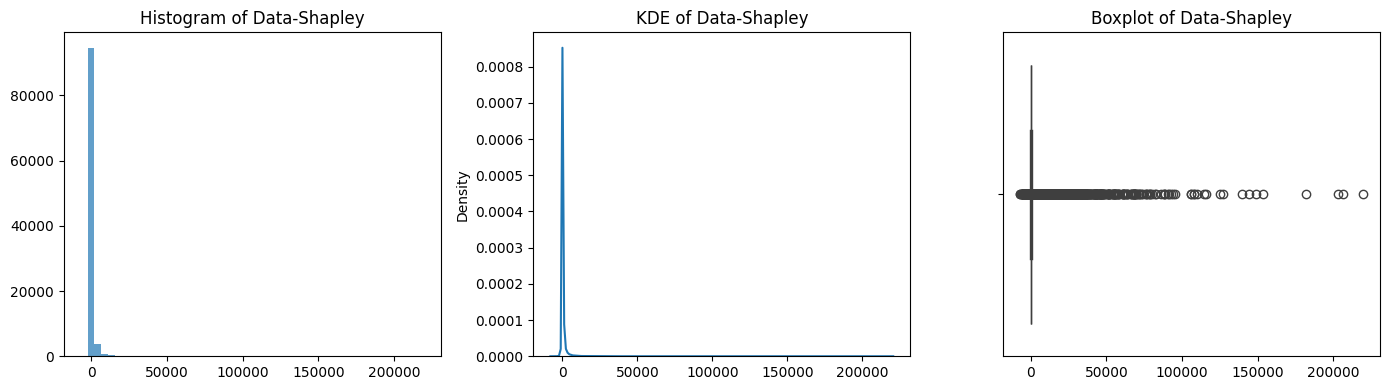

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
ds = data_shapley.numpy()
plt.figure(figsize=(14,4))
plt.subplot(1,3,1)
plt.hist(ds, bins=50, alpha=0.7)
plt.title("Histogram of Data-Shapley")
plt.subplot(1,3,2)
sns.kdeplot(ds)
plt.title("KDE of Data-Shapley")
plt.subplot(1,3,3)
sns.boxplot(x=ds)
plt.title("Boxplot of Data-Shapley")
plt.tight_layout()
plt.show()


正 Shapley 样本数量: 63952
负 Shapley 样本数量: 36048


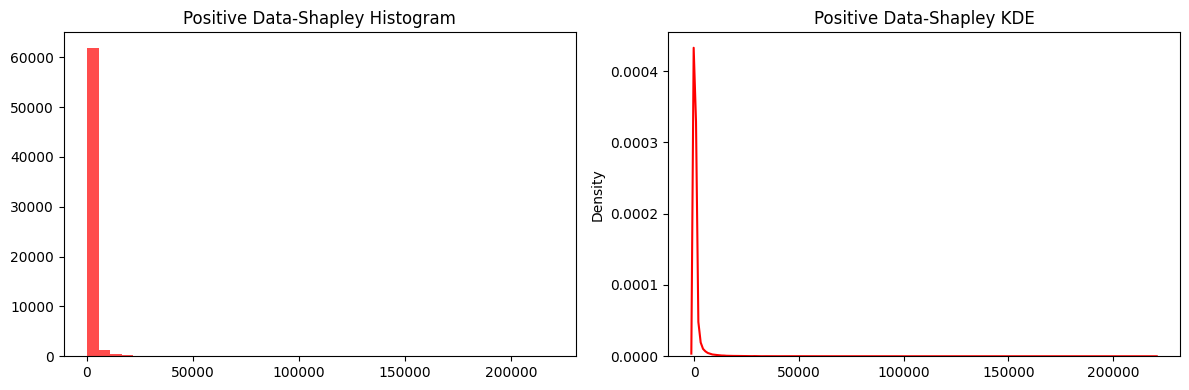

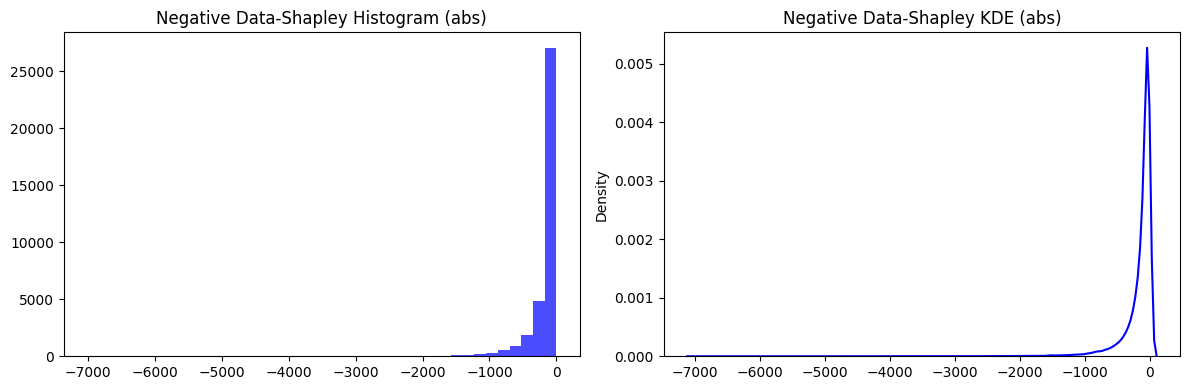

              数量          均值            方差          最小值            最大值  \
正 Shapley  63952  953.072266  1.819172e+07     0.000565  219483.093750   
负 Shapley  36048 -158.890121  8.644886e+04 -7009.794922      -0.000489   

                 绝对均值  
正 Shapley  953.072266  
负 Shapley  158.890121  


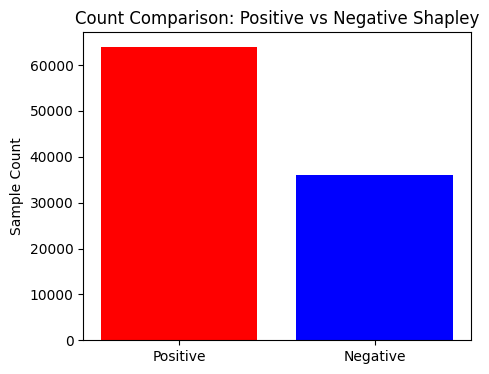

In [40]:
ds = data_shapley.numpy()
positive_vals = ds[ds > 0]
negative_vals = ds[ds < 0]
print("正 Shapley 样本数量:", len(positive_vals))
print("负 Shapley 样本数量:", len(negative_vals))
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.hist(positive_vals, bins=40, alpha=0.7, color='red')
plt.title("Positive Data-Shapley Histogram")
plt.subplot(1,2,2)
sns.kdeplot(positive_vals, color='red')
plt.title("Positive Data-Shapley KDE")
plt.tight_layout()
plt.show()

abs_negative = negative_vals
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.hist(abs_negative, bins=40, alpha=0.7, color='blue')
plt.title("Negative Data-Shapley Histogram (abs)")
plt.subplot(1,2,2)
sns.kdeplot(abs_negative, color='blue')
plt.title("Negative Data-Shapley KDE (abs)")
plt.tight_layout()
plt.show()
import numpy as np
import pandas as pd

stats = {
    "数量": [len(positive_vals), len(negative_vals)],
    "均值": [positive_vals.mean(), negative_vals.mean()],
    "方差": [positive_vals.var(), negative_vals.var()],
    "最小值": [positive_vals.min(), negative_vals.min()],
    "最大值": [positive_vals.max(), negative_vals.max()],
    "绝对均值": [np.abs(positive_vals).mean(), np.abs(negative_vals).mean()],
}
df_stats = pd.DataFrame(stats, index=["正 Shapley", "负 Shapley"])
print(df_stats)
plt.figure(figsize=(5,4))
plt.bar(["Positive", "Negative"], [len(positive_vals), len(negative_vals)], color=["red","blue"])
plt.title("Count Comparison: Positive vs Negative Shapley")
plt.ylabel("Sample Count")
plt.show()


需要明确区分的是，Data Shapley 与用于解释机器学习模型的特征重要性 Shapley 值（如 SHAP）是两种截然不同的概念。前者旨在量化单个数据点对模型整体性能的贡献，属于数据集价值评估范畴；而后者则是解释已训练好的模型中，每个输入特征对于某次特定预测的贡献程度，属于模型可解释性范畴,看相关性两者相关性会比较低

In [42]:
import shap
import numpy as np
import torch
import time

# ========== 1. 包装模型：numpy → torch → numpy ==========
def model_np(x_np):
    x = torch.tensor(x_np, dtype=torch.float32)
    with torch.no_grad():
        pred = model(x)
    return pred.numpy().reshape(-1)

# ========== 2. 选择小样本 ==========
small_X = X.to_numpy()          # ← 修复点
small_y = y.to_numpy()

# 选 200 个背景样本
background = small_X[:200]

# ========== 3. Kernel SHAP（模型无关，非常慢）==========
explainer = shap.KernelExplainer(model_np, background)

t0 = time.time()
phi_kernel = explainer.shap_values(small_X[:10])   # 对前10个样本解释
t1 = time.time()

print("Kernel SHAP time:", t1 - t0)
print("phi shape:", np.array(phi_kernel).shape)



Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 10/10 [00:04<00:00,  2.20it/s]

Kernel SHAP time: 4.5575878620147705
phi shape: (10, 151)
